In [1]:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
full_data.shape[0] - full_data_cln.shape[0]

180

# Data Cleaning

In [2]:
# read data
file_path = "./hotel_bookings.csv"
full_data = pd.read_csv(file_path)
full_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# stats for missing values
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
## replace missing values:
# only 3 columns have missing values: country; deposit_type; company
replace_dict = {"children:": 0.0, "country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(replace_dict)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# drop entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

In [5]:
# after cleaning, there is 119210 samples
full_data_cln.shape

(119210, 32)

# Cancellation Prediction

In [30]:
cancel_corr = full_data_cln.corr()["is_canceled"]
corr = cancel_corr.abs().sort_values(ascending=False)

In [39]:
ys = corr[1:]
xs = ['lead_time', 'total_of_special_requests', 'required_car_parking_spaces',\
     'booking_changes', 'previous_cancellations', 'is_repeated_guest', \
     'company', 'adults', 'previous_bookings_not_canceled', 'days_in_waiting_list',\
     'agent', 'adr', 'babies', 'stays_in_week_nights', 'arrival_date_year', \
     'arrival_date_week_number', 'arrival_date_day_of_month', 'children', 'stays_in_weekend_nights']

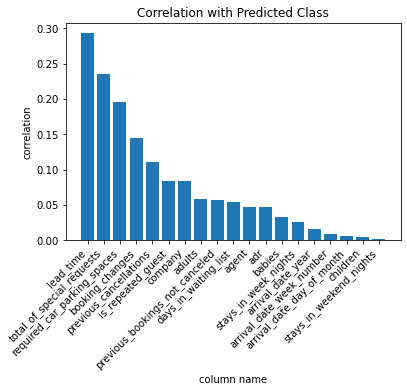

In [45]:
plt.bar(xs, ys)
plt.xticks(rotation=45, ha='right')
plt.xlabel("column name")
plt.ylabel("correlation")
plt.title("Correlation with Predicted Class")
plt.show()

In [7]:
cancel_counts = full_data_cln['is_canceled'].value_counts()
cancel_counts

0    75011
1    44199
Name: is_canceled, dtype: int64

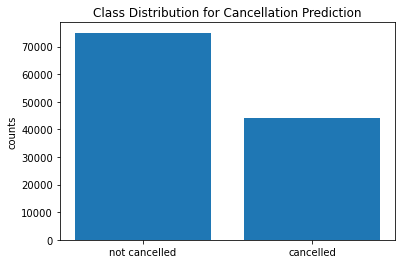

0.629234124653972

In [8]:
# naive accuracy
plt.bar(["not cancelled", "cancelled"], cancel_counts)
plt.ylabel("counts")
plt.title("Class Distribution for Cancellation Prediction")
plt.show()
cancel_counts[0] / (cancel_counts[0] + cancel_counts[1])

In [9]:
## choose the 10 most useful features based on correlation

# all features are numerical
full_feature_list = ["lead_time", "total_of_special_requests", \
                    "required_car_parking_spaces", "booking_changes",\
                    "previous_cancellations", "is_repeated_guest",\
                    "agent", "adults", "previous_bookings_not_canceled",\
                    "days_in_waiting_list"]

X = full_data_cln.drop(["is_canceled"], axis=1)[full_feature_list]
y = full_data_cln["is_canceled"]

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

num_folds = 5 # 5 fold cross validation = 80% train, 20% validation

In [11]:
def train(model, model_name, X, y, num_folds):    
    clf = make_pipeline(StandardScaler(), model)
    scores = cross_val_score(clf, X, y, cv=num_folds, scoring='accuracy', n_jobs=-1)
    print("{} performance: {:.2f} +- {:.2f}".format(model_name, np.mean(scores), np.std(scores)))

In [12]:
# init model - Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model_name = "Gaussian Naive Bayes"

# train
train(model, model_name, X, y, num_folds)

Gaussian Naive Bayes performance: 0.46 +- 0.06


In [13]:
# init model - Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model_name = "Logistic Regression"

# train
train(model, model_name, X, y, num_folds)

Logistic Regression performance: 0.69 +- 0.07


In [15]:
# init model - XGBoost
from xgboost import XGBClassifier
model = XGBClassifier()
model_name = "XGBoost"

# train
train(model, model_name, X, y, num_folds)

XGBoost performance: 0.71 +- 0.05


In [22]:
# init model - simple neural network
import torch
from torch import nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super(SimpleNet, self).__init__()
        
        self.layer_1 = nn.Linear(input_dim, hid_dim) 
        self.layer_2 = nn.Linear(hid_dim, hid_dim)
        self.layer_out = nn.Linear(hid_dim, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(hid_dim)
        self.batchnorm2 = nn.BatchNorm1d(hid_dim)
        
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        x = torch.sigmoid(x)
        return x

from sklearn.metrics import confusion_matrix, classification_report
import ipdb
    
def evaluate(model, dataloader):
    correct = 0
    total = 0

    y_pred_list = []
    y_gt_list = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            labels = labels.unsqueeze(-1)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

    print('Accuracy of the network on test set: %d %%' % (
        100 * correct / total))

In [25]:
from sklearn.model_selection import KFold

def train_ann(X, y, num_folds, lr = 0.01, hid_dim = 64, loss_func = nn.BCELoss(), run_cv=False):
    
    kfold = KFold(n_splits=num_folds, shuffle=True)
    
    # grid search 
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        # Print
        print(f'FOLD {fold}')

        # init data
        train_data = []
        test_data = []
        X_train = X.to_numpy()[train_ids]
        y_train = y.to_numpy()[train_ids]
        X_test = X.to_numpy()[test_ids]
        y_test = y.to_numpy()[test_ids]
        # normalize data
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        X_test_transformed = scaler.transform(X_test)

        for i in range(len(X_train)):
            train_data.append([X_train_transformed[i], y_train[i]])
        for i in range(len(X_test)):
            test_data.append([X_test_transformed[i], y_test[i]])

        trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=512)
        testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=512)

        # init model
        simple_ann = SimpleNet(X.shape[1], hid_dim)

        # init training
        optimizer = torch.optim.SGD(simple_ann.parameters(), lr=lr, momentum=0.9)
        criterion = loss_func

        # training
        for epoch in range(num_epoch):  
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.float(), labels.float()
                labels = labels.unsqueeze(-1)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = simple_ann(inputs)
                loss = criterion(outputs, labels)
                
                if i%200 == 199:
                    _, predicted = torch.max(outputs.data, 1)
                    num_correct = (predicted == labels.squeeze()).sum().item()
                    print(loss.item(), num_correct / 512.0)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

            if epoch % 10 == 9:
                print('[epoch %d] loss: %.3f' %
                      (epoch + 1, running_loss / len(trainloader)))
        simple_ann.eval()
        evaluate(simple_ann, trainloader)
        evaluate(simple_ann, testloader)
        simple_ann.train()
        if not run_cv:
            break

In [27]:
lr_list = [0.1, 0.03, 0.01, 0.003, 0.001]
hid_dim_list = [256, 64, 16]
loss_list = [nn.BCELoss()]

num_epoch = 50

for loss in loss_list:
    for hid_dim in hid_dim_list: 
        for lr in lr_list:
            print(lr, hid_dim, loss)
            train_ann(X, y, 5, lr, hid_dim, loss, False)

0.1 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.477
[epoch 20] loss: 0.466
[epoch 30] loss: 0.461
[epoch 40] loss: 0.456
[epoch 50] loss: 0.453
Accuracy of the network on test set: 63 %
Accuracy of the network on test set: 62 %
0.03 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.479
[epoch 20] loss: 0.473
[epoch 30] loss: 0.468
[epoch 40] loss: 0.462
[epoch 50] loss: 0.459
Accuracy of the network on test set: 62 %
Accuracy of the network on test set: 62 %
0.01 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.476
[epoch 20] loss: 0.470
[epoch 30] loss: 0.465
[epoch 40] loss: 0.461
[epoch 50] loss: 0.457
Accuracy of the network on test set: 62 %
Accuracy of the network on test set: 62 %
0.003 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.485
[epoch 20] loss: 0.479
[epoch 30] loss: 0.476
[epoch 40] loss: 0.474
[epoch 50] loss: 0.471
Accuracy of the network on test set: 62 %
Accuracy of the network on test set: 62 %
0.001 256 BCELoss()
FOLD 0
[epoch 10] loss: 0.489
[epoch 20] loss: 0.484
[epoch 30] loss: 0.481
[epo

KeyboardInterrupt: 